<a href="https://colab.research.google.com/github/dickytrianza/AllAboutBugBounty/blob/master/revision/lopez%26cadavid/zaid_baseline_amd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import os
import random
import time

from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, log_loss
from xgboost import XGBClassifier
from scipy.stats import mode
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split

In [3]:
os.environ['PYTHONHASHSEED'] = '42'
random.seed(42)
np.random.seed(42)

# Fix TensorFlow randomness
tf.random.set_seed(42)

# set deterministic ops
os.environ['TF_DETERMINISTIC_OPS'] = '1'

# Load Dataset

In [4]:
df_raw = pd.read_csv('/content/drive/MyDrive/FYP/Datasets/train.csv')
header = df_raw.columns[0].split(";")
parsed_data = df_raw.iloc[:, 0].apply(lambda x: list(map(int, x.split(';'))))
df = pd.DataFrame(parsed_data.tolist(), columns=header)

print("Sample Lopez & Cadaviz Data:")
display(df.sample(5))

Sample Lopez & Cadaviz Data:


,android,android.app.cts.permission.TEST_GRANTED,android.intent.category.MASTER_CLEAR.permission.C2D_MESSAGE,android.os.cts.permission.TEST_GRANTED,android.permission.ACCESS_ALL_DOWNLOADS,android.permission.ACCESS_ALL_EXTERNAL_STORAGE,android.permission.ACCESS_BLUETOOTH_SHARE,android.permission.ACCESS_CACHE_FILESYSTEM,android.permission.ACCESS_CHECKIN_PROPERTIES,android.permission.ACCESS_COARSE_LOCATION,...,com.android.voicemail.permission.WRITE_VOICEMAIL,com.foo.mypermission,com.foo.mypermission2,org.chromium.chrome.shell.permission.C2D_MESSAGE,org.chromium.chrome.shell.permission.DEBUG,org.chromium.chrome.shell.permission.SANDBOX,org.chromium.chromecast.shell.permission.SANDBOX,org.chromium.content_shell.permission.SANDBOX,test_permission,type
198,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
396,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
33,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
208,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
93,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1


# Data Preprocessing

## Split Dataset

In [5]:
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

## Feature Selection

/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [  0   1   2   3   4   5   6   8  10  13  15  16  17  20  21  23  24  25
  28  29  30  31  32  33  34  36  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  61  62  65  66  67
  68  69  70  71  73  75  79  80  81  82  83  84  85  86  93  94  95  96
  97  98  99 100 101 102 103 104 108 110 111 114 115 117 118 119 120 122
 123 126 127 129 131 133 135 136 137 139 141 142 143 145 146 147 148 149
 150 151 152 153 154 155 156 157 158 159 161 162 164 166 167 168 170 171
 172 173 174 176 178 181 183 185 186 187 189 191 192 193 194 196 199 200
 201 203 205 206 211 212 213 214 215 216 217 218 220 221 222 224 226 227
 228 229 230 231 232 234 236 237 238 239 241 243 244 245 246 247 248 249
 250 251 252 254 255 256 257 258 260 261 263 268 270 272 273 274 278 280
 282 285 286 287 288 289 290 291 292 293 294 295 296 297 298 299 300 301
 302 3

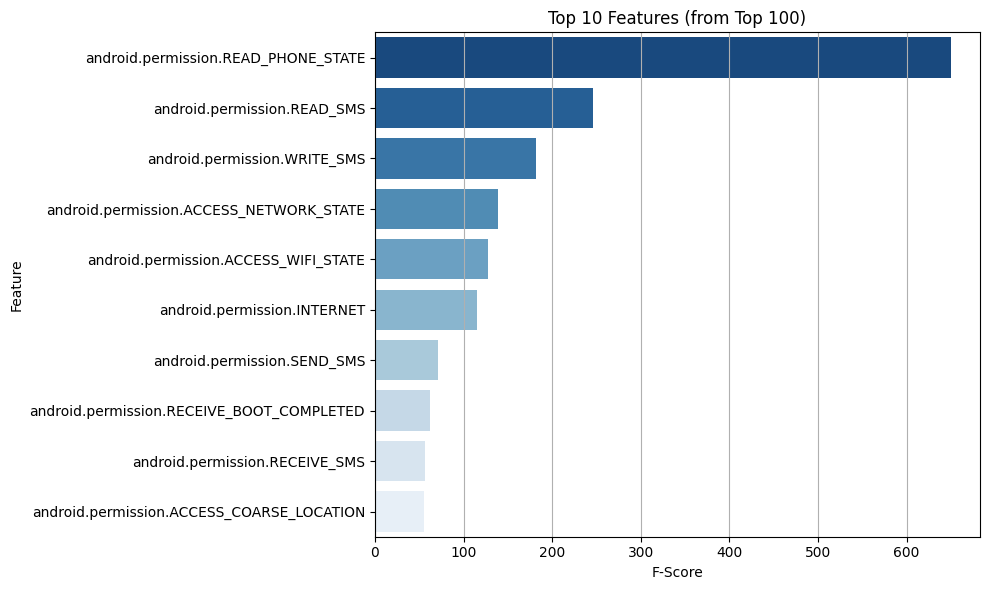

In [6]:
# Select top 100 features
selector = SelectKBest(score_func=f_classif, k=100)
selector.fit(X_train, y_train)

# Get selected feature indices and names
selected_indices = selector.get_support(indices=True)
selected_columns = X_train.columns[selected_indices]

# Apply selected features to train/test
X_train_top100 = X_train.iloc[:, selected_indices]
X_test_top100 = X_test.iloc[:, selected_indices]

# Scale them
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_top100)
X_test_scaled = scaler.transform(X_test_top100)

# Show top 10 most important (by F-score) from the 100
feature_scores = pd.DataFrame({
    'Feature': selected_columns,
    'F-Score': selector.scores_[selected_indices]
}).dropna().sort_values(by='F-Score', ascending=False)

# Plot top 10
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_scores.head(10), x='F-Score', y='Feature', palette='Blues_r')
plt.title("Top 10 Features (from Top 100)")
plt.xlabel("F-Score")
plt.ylabel("Feature")
plt.grid(axis='x')
plt.tight_layout()
plt.show()


## Feature Scaling

In [7]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_top100)
X_test_scaled = scaler.transform(X_test_top100)


In [8]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(zip(np.unique(y_train), class_weights))

# Reshape for CNN

In [9]:
X_train_cnn = X_train_scaled.reshape(-1, 100, 1)
X_test_cnn = X_test_scaled.reshape(-1, 100, 1)

input_layer = Input(shape=(100, 1))

# CNN Model

In [10]:
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
from tensorflow.keras.callbacks import EarlyStopping

def build_cnn_model():
    input_layer = Input(shape=(100, 1))
    x = Conv1D(32, kernel_size=3, activation='relu')(input_layer)
    x = MaxPooling1D(pool_size=2)(x)
    x = Conv1D(64, kernel_size=3, activation='relu')(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu', name="feature_dense")(x)
    x = Dropout(0.6)(x)
    output = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=input_layer, outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold = 1
f1_scores = []

# Store loss history
all_train_loss = []
all_val_loss = []
train_times = []  # ⏱️ Store training times per fold

for train_index, val_index in kf.split(X_train_scaled):
    X_tr, X_val = X_train_scaled[train_index], X_train_scaled[val_index]
    y_tr, y_val = y_train.values[train_index], y_train.values[val_index]

    X_tr_cnn = X_tr.reshape(-1, 100, 1)
    X_val_cnn = X_val.reshape(-1, 100, 1)

    cnn_model = build_cnn_model()
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    start_time = time.time()
    history = cnn_model.fit(
        X_tr_cnn, y_tr,
        validation_data=(X_val_cnn, y_val),
        epochs=50,
        batch_size=32,
        callbacks=[early_stop],
        verbose=0
    )
    end_time = time.time()
    elapsed = end_time - start_time
    train_times.append(elapsed)

    preds = (cnn_model.predict(X_val_cnn) > 0.5).astype(int)
    f1 = f1_score(y_val, preds)
    f1_scores.append(f1)

    all_train_loss.append(history.history['loss'])
    all_val_loss.append(history.history['val_loss'])

    print(f"Fold {fold} F1 Score: {f1:.4f} | Training Time: {elapsed:.2f} sec")
    fold += 1

# Optional: report overall training time statistics
print("\nCNN Lopez Training Times per Fold:", train_times)
print("Mean Time: {:.2f} sec | Std Dev: {:.2f} sec".format(np.mean(train_times), np.std(train_times)))

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step 
Fold 1 F1 Score: 0.9722 | Training Time: 13.47 sec
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Fold 2 F1 Score: 0.8696 | Training Time: 5.92 sec
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Fold 3 F1 Score: 0.9796 | Training Time: 5.40 sec
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
Fold 4 F1 Score: 0.8955 | Training Time: 4.00 sec


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
Fold 5 F1 Score: 0.8421 | Training Time: 3.84 sec

CNN Lopez Training Times per Fold: [13.467639207839966, 5.920263290405273, 5.4016523361206055, 3.998504161834717, 3.8401029109954834]
Mean Time: 6.53 sec | Std Dev: 3.56 sec


## Evaluation

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

 Classification Report (Training Data):
              precision    recall  f1-score   support

           0       0.88      0.92      0.90       159
           1       0.92      0.87      0.90       159

    accuracy                           0.90       318
   macro avg       0.90      0.90      0.90       318
weighted avg       0.90      0.90      0.90       318



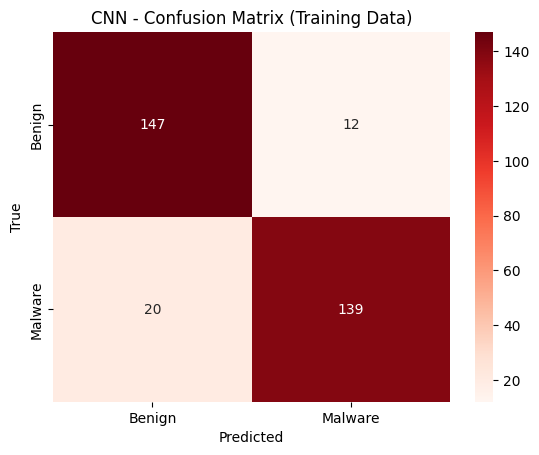

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

 Classification Report (Testing Data):
              precision    recall  f1-score   support

           0       0.88      0.93      0.90        40
           1       0.92      0.88      0.90        40

    accuracy                           0.90        80
   macro avg       0.90      0.90      0.90        80
weighted avg       0.90      0.90      0.90        80



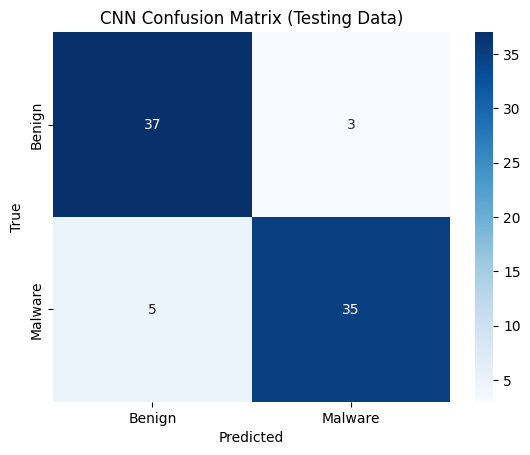

In [11]:
# Training Evaluation - CNN
cnn_train_pred = (cnn_model.predict(X_train_cnn) > 0.5).astype(int)
print("\n Classification Report (Training Data):")
print(classification_report(y_train, cnn_train_pred))

sns.heatmap(confusion_matrix(y_train, cnn_train_pred), annot=True, fmt='d', cmap='Reds',
            xticklabels=["Benign", "Malware"], yticklabels=["Benign", "Malware"])
plt.title("CNN - Confusion Matrix (Training Data)")
plt.xlabel("Predicted"); plt.ylabel("True"); plt.show()

# Testing Evaluation - CNN
cnn_test_pred = (cnn_model.predict(X_test_cnn) > 0.5).astype(int)
print("\n Classification Report (Testing Data):")
print(classification_report(y_test, cnn_test_pred))

sns.heatmap(confusion_matrix(y_test, cnn_test_pred), annot=True, fmt='d', cmap='Blues',
            xticklabels=["Benign", "Malware"], yticklabels=["Benign", "Malware"])
plt.title("CNN Confusion Matrix (Testing Data)")
plt.xlabel("Predicted"); plt.ylabel("True"); plt.show()

# XGBoost Model

🔧 Starting XGBoost Tuning...
Fitting 5 folds for each of 16 candidates, totalling 80 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:02:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


✅ Tuning Time: 6.16 seconds
Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}
✅ Training Time: 0.06 seconds


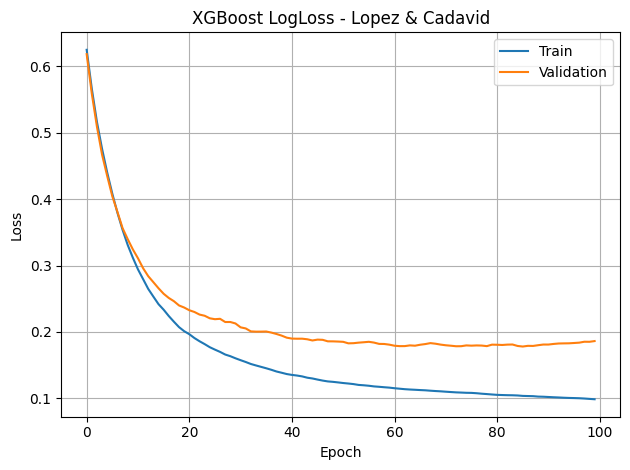

In [12]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

# Define parameter grid
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0]
}

# Initialize base model
base_xgb = XGBClassifier(eval_metric='logloss', use_label_encoder=False)

# GridSearch with 5-Fold CV
grid_search = GridSearchCV(
    estimator=base_xgb,
    param_grid=param_grid,
    scoring='f1',
    cv=5,
    verbose=1,
    n_jobs=-1
)

# ⏱️ Tuning Time
print("🔧 Starting XGBoost Tuning...")
start_tune = time.time()
grid_search.fit(X_train_scaled, y_train)
end_tune = time.time()
print("✅ Tuning Time: {:.2f} seconds".format(end_tune - start_tune))

# Get best model
print("Best Parameters:", grid_search.best_params_)

# ⏱️ Training Time
xgb_model = XGBClassifier(
    eval_metric='logloss',
    use_label_encoder=False,
    **grid_search.best_params_
)
start_train = time.time()
xgb_model.fit(
    X_train_scaled, y_train,
    eval_set=[(X_train_scaled, y_train), (X_test_scaled, y_test)],
    verbose=False
)
end_train = time.time()
print("✅ Training Time: {:.2f} seconds".format(end_train - start_train))

# 📉 Log Loss Curve
xgb_eval = xgb_model.evals_result()
plt.plot(xgb_eval['validation_0']['logloss'], label='Train')
plt.plot(xgb_eval['validation_1']['logloss'], label='Validation')
plt.title("XGBoost LogLoss - Lopez & Cadavid")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Evaluation


 XGBoost Classification Report (Training Data):
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       159
           1       0.99      0.96      0.97       159

    accuracy                           0.97       318
   macro avg       0.97      0.97      0.97       318
weighted avg       0.97      0.97      0.97       318



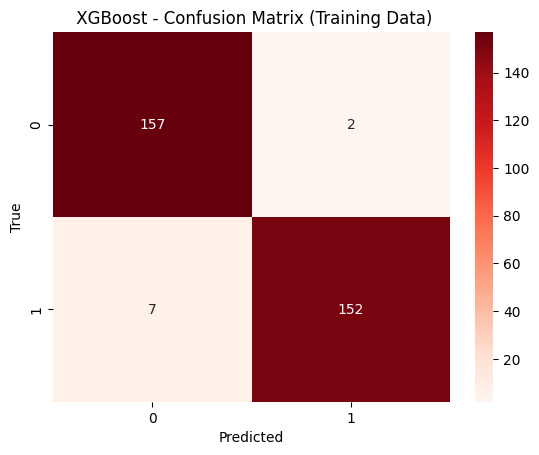


 XGBoost Classification Report (Testing Data):
              precision    recall  f1-score   support

           0       0.90      0.95      0.93        40
           1       0.95      0.90      0.92        40

    accuracy                           0.93        80
   macro avg       0.93      0.93      0.92        80
weighted avg       0.93      0.93      0.92        80



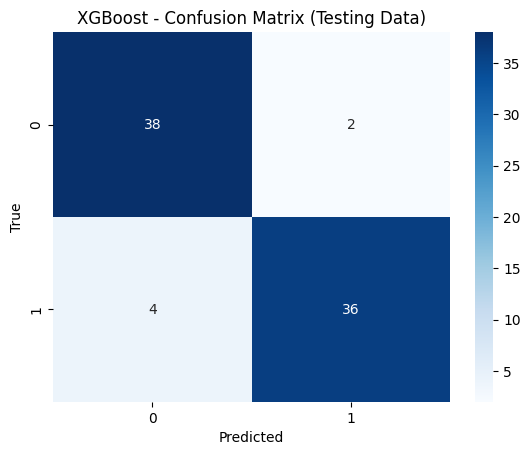

In [13]:
# Training Evaluation - XGBoost
xgb_train_pred = xgb_model.predict(X_train_scaled)
print("\n XGBoost Classification Report (Training Data):")
print(classification_report(y_train, xgb_train_pred))

sns.heatmap(confusion_matrix(y_train, xgb_train_pred), annot=True, fmt='d', cmap='Reds')
plt.title(" XGBoost - Confusion Matrix (Training Data)")
plt.xlabel("Predicted"); plt.ylabel("True"); plt.show()

# Testing Evaluation - XGBoost
xgb_test_pred = xgb_model.predict(X_test_scaled)
print("\n XGBoost Classification Report (Testing Data):")
print(classification_report(y_test, xgb_test_pred))

sns.heatmap(confusion_matrix(y_test, xgb_test_pred), annot=True, fmt='d', cmap='Blues')
plt.title("XGBoost - Confusion Matrix (Testing Data)")
plt.xlabel("Predicted"); plt.ylabel("True"); plt.show()

# Hybrid CNN and XGBoost Model

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Train Features Shape: (318, 128)
Test Features Shape: (80, 128)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:02:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


✅ Hybrid Training Time: 0.23 seconds
✅ Hybrid Inference Time: 0.00 seconds


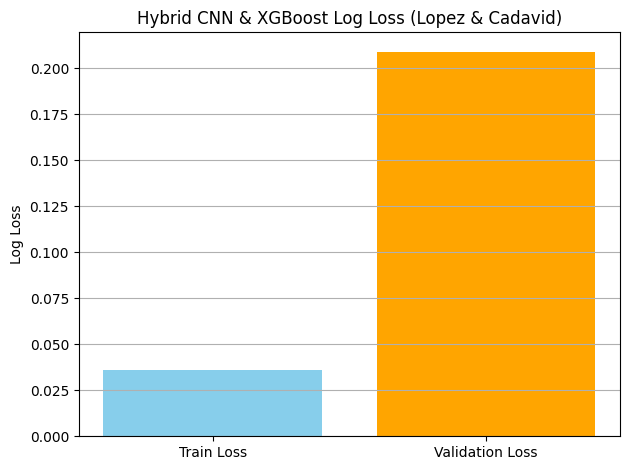

In [14]:
# 1. Feature Extractor from CNN
feature_extractor = Model(
    inputs=cnn_model.input,
    outputs=cnn_model.get_layer("feature_dense").output
)

# 2. Extract features
train_features = feature_extractor.predict(X_train_cnn)
test_features = feature_extractor.predict(X_test_cnn)

print("Train Features Shape:", train_features.shape)
print("Test Features Shape:", test_features.shape)

# 3. Train XGBoost on extracted features
xgb_hybrid = XGBClassifier(
    eval_metric='logloss',
    use_label_encoder=False,
    **grid_search.best_params_  # from previous tuning
)

start_train = time.time()
xgb_hybrid.fit(train_features, y_train)
end_train = time.time()
print("✅ Hybrid Training Time: {:.2f} seconds".format(end_train - start_train))

# 4. Inference
start_infer = time.time()
y_pred_hybrid = xgb_hybrid.predict(test_features)
end_infer = time.time()
print("✅ Hybrid Inference Time: {:.2f} seconds".format(end_infer - start_infer))

# 5. Log Loss Plot
train_preds_hybrid_proba = xgb_hybrid.predict_proba(train_features)[:, 1]
test_preds_hybrid_proba = xgb_hybrid.predict_proba(test_features)[:, 1]

train_loss = log_loss(y_train, train_preds_hybrid_proba)
val_loss = log_loss(y_test, test_preds_hybrid_proba)

plt.bar(['Train Loss', 'Validation Loss'], [train_loss, val_loss], color=['skyblue', 'orange'])
plt.title("Hybrid CNN & XGBoost Log Loss (Lopez & Cadavid)")
plt.ylabel("Log Loss")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

## Evaluation


 Hybrid Classification Report (Training Data):
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       159
           1       1.00      0.99      0.99       159

    accuracy                           0.99       318
   macro avg       0.99      0.99      0.99       318
weighted avg       0.99      0.99      0.99       318



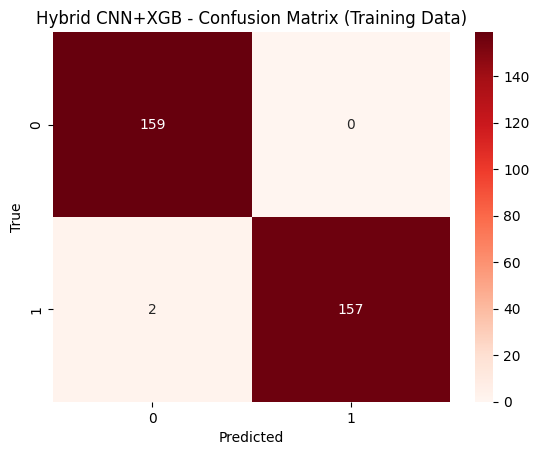


 Hybrid Classification Report (Testing Data):
              precision    recall  f1-score   support

           0       0.95      0.90      0.92        40
           1       0.90      0.95      0.93        40

    accuracy                           0.93        80
   macro avg       0.93      0.93      0.92        80
weighted avg       0.93      0.93      0.92        80



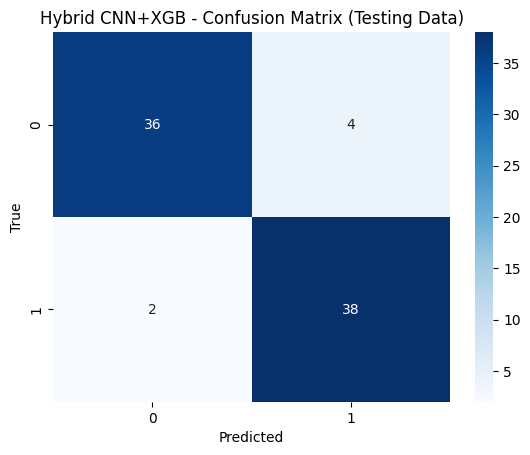

In [15]:
# Training Evaluation - Hybrid
hybrid_train_pred = xgb_hybrid.predict(train_features)
print("\n Hybrid Classification Report (Training Data):")
print(classification_report(y_train, hybrid_train_pred))

sns.heatmap(confusion_matrix(y_train, hybrid_train_pred), annot=True, fmt='d', cmap='Reds')
plt.title("Hybrid CNN+XGB - Confusion Matrix (Training Data)")
plt.xlabel("Predicted"); plt.ylabel("True"); plt.show()

# Testing Evaluation - Hybrid
hybrid_test_pred = xgb_hybrid.predict(test_features)
print("\n Hybrid Classification Report (Testing Data):")
print(classification_report(y_test, hybrid_test_pred))

sns.heatmap(confusion_matrix(y_test, hybrid_test_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Hybrid CNN+XGB - Confusion Matrix (Testing Data)")
plt.xlabel("Predicted"); plt.ylabel("True"); plt.show()

# Ensemble Models

# Hard Voting

In [16]:
# Predict CNN output first
y_pred_cnn = (cnn_model.predict(X_test_cnn) > 0.5).astype(int)

# Predict XGBoost if not done yet
y_pred_xgb = xgb_model.predict(X_test_scaled)

# Prepare binary predictions
y_pred_cnn_bin = y_pred_cnn.flatten()
y_pred_hard = mode(np.vstack([y_pred_cnn_bin, y_pred_xgb]).T, axis=1).mode.flatten()


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


## Evaluation


 Hard Voting Classification Report (Training Data):
              precision    recall  f1-score   support

           0       0.88      0.99      0.93       159
           1       0.99      0.87      0.93       159

    accuracy                           0.93       318
   macro avg       0.94      0.93      0.93       318
weighted avg       0.94      0.93      0.93       318



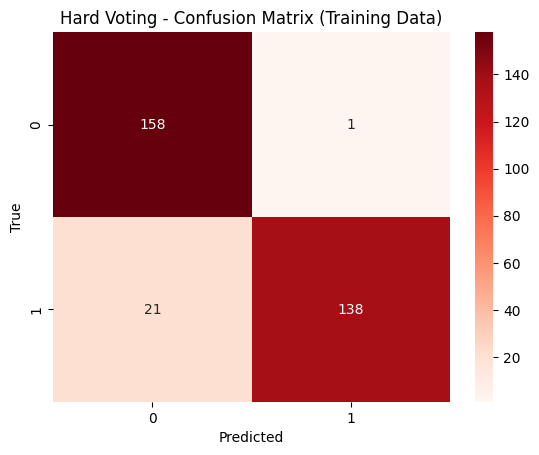


 Hard Voting Classification Report (Testing Data):
              precision    recall  f1-score   support

           0       0.83      1.00      0.91        40
           1       1.00      0.80      0.89        40

    accuracy                           0.90        80
   macro avg       0.92      0.90      0.90        80
weighted avg       0.92      0.90      0.90        80



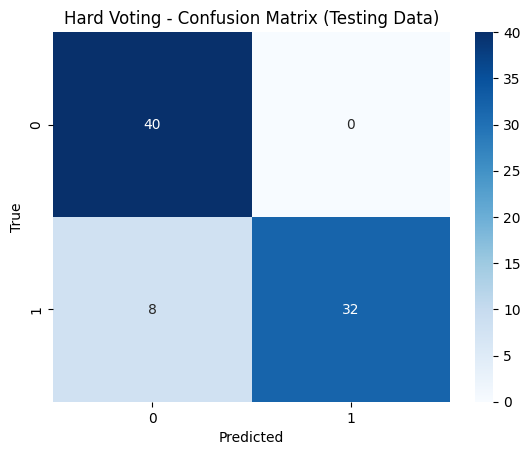

In [17]:
# Training Evaluation - Hard Voting
hard_train_pred = mode(np.vstack([cnn_train_pred.flatten(), xgb_train_pred]).T, axis=1).mode.flatten()
print("\n Hard Voting Classification Report (Training Data):")
print(classification_report(y_train, hard_train_pred))

sns.heatmap(confusion_matrix(y_train, hard_train_pred), annot=True, fmt='d', cmap='Reds')
plt.title("Hard Voting - Confusion Matrix (Training Data)")
plt.xlabel("Predicted"); plt.ylabel("True"); plt.show()

# Testing Evaluation - Hard Voting
hard_test_pred = mode(np.vstack([cnn_test_pred.flatten(), xgb_test_pred]).T, axis=1).mode.flatten()
print("\n Hard Voting Classification Report (Testing Data):")
print(classification_report(y_test, hard_test_pred))

sns.heatmap(confusion_matrix(y_test, hard_test_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Hard Voting - Confusion Matrix (Testing Data)")
plt.xlabel("Predicted"); plt.ylabel("True"); plt.show()

# Soft Voting

In [18]:
cnn_probs = cnn_model.predict(X_test_cnn).flatten()
xgb_probs = xgb_model.predict_proba(X_test_scaled)[:, 1]
# Step 1: Combine CNN + XGB probabilities
soft_test_avg = 0.6 * cnn_probs + 0.4 * xgb_probs

# Step 2: Find the best threshold using F1 score
from sklearn.metrics import f1_score

thresholds = np.arange(0.1, 0.9, 0.01)
f1_scores = []

for t in thresholds:
    preds = (soft_test_avg > t).astype(int)
    f1 = f1_score(y_test, preds)
    f1_scores.append(f1)

best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

print(f"Best threshold: {best_threshold:.2f} with F1: {f1_scores[best_idx]:.4f}")

# Step 3: Use best threshold
y_pred_soft = (soft_test_avg > best_threshold).astype(int)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Best threshold: 0.49 with F1: 0.9512


## Evaluation

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

 Soft Voting Classification Report (Training Data):
              precision    recall  f1-score   support

           0       0.96      0.97      0.97       159
           1       0.97      0.96      0.97       159

    accuracy                           0.97       318
   macro avg       0.97      0.97      0.97       318
weighted avg       0.97      0.97      0.97       318



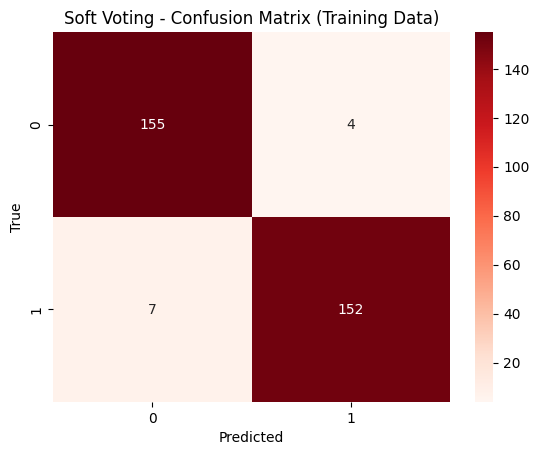

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

 Soft Voting Classification Report (Testing Data):
              precision    recall  f1-score   support

           0       0.95      0.95      0.95        40
           1       0.95      0.95      0.95        40

    accuracy                           0.95        80
   macro avg       0.95      0.95      0.95        80
weighted avg       0.95      0.95      0.95        80



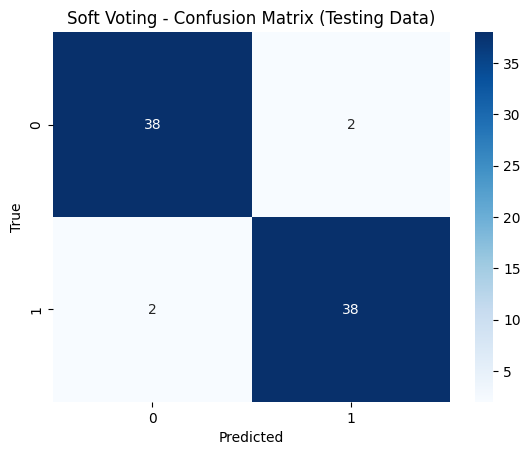

In [19]:
# Training Evaluation - Soft Voting
cnn_train_proba = cnn_model.predict(X_train_cnn).flatten()
xgb_train_proba = xgb_model.predict_proba(X_train_scaled)[:, 1]
soft_train_avg = 0.4 * cnn_train_proba + 0.6 * xgb_train_proba
soft_train_pred = (soft_train_avg > 0.5).astype(int)

print("\n Soft Voting Classification Report (Training Data):")
print(classification_report(y_train, soft_train_pred))

sns.heatmap(confusion_matrix(y_train, soft_train_pred), annot=True, fmt='d', cmap='Reds')
plt.title("Soft Voting - Confusion Matrix (Training Data)")
plt.xlabel("Predicted"); plt.ylabel("True"); plt.show()

# Testing Evaluation - Soft Voting
cnn_test_proba = cnn_model.predict(X_test_cnn).flatten()
xgb_test_proba = xgb_model.predict_proba(X_test_scaled)[:, 1]
soft_test_avg = 0.4 * cnn_test_proba + 0.6 * xgb_test_proba
soft_test_pred = (soft_test_avg > 0.5).astype(int)

print("\n Soft Voting Classification Report (Testing Data):")
print(classification_report(y_test, soft_test_pred))

sns.heatmap(confusion_matrix(y_test, soft_test_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Soft Voting - Confusion Matrix (Testing Data)")
plt.xlabel("Predicted"); plt.ylabel("True"); plt.show()

# Summary Report

In [20]:
y_pred_test_cnn = y_pred_cnn
y_pred_test_xgb = y_pred_xgb
y_pred_test_hybrid = y_pred_hybrid
y_pred_test_hard = y_pred_hard
y_pred_test_soft = y_pred_soft

# === Generate classification reports as dictionaries ===
report_cnn = classification_report(y_test, y_pred_test_cnn, output_dict=True)
report_xgb = classification_report(y_test, y_pred_test_xgb, output_dict=True)
report_hybrid = classification_report(y_test, y_pred_test_hybrid, output_dict=True)
report_hard = classification_report(y_test, y_pred_test_hard, output_dict=True)
report_soft = classification_report(y_test, y_pred_test_soft, output_dict=True)

# === Create the results summary DataFrame ===
results = pd.DataFrame({
    "Model": [
        "CNN Only",
        "XGBoost Only",
        "Hybrid (CNN & XGB)",
        "Ensemble (Hard Vote)",
        "Ensemble (Soft Vote)"
    ],
    "Accuracy": [
        accuracy_score(y_test, y_pred_test_cnn),
        accuracy_score(y_test, y_pred_test_xgb),
        accuracy_score(y_test, y_pred_test_hybrid),
        accuracy_score(y_test, y_pred_test_hard),
        accuracy_score(y_test, y_pred_test_soft),
    ],
    "Precision Malware": [
        report_cnn['1']['precision'],
        report_xgb['1']['precision'],
        report_hybrid['1']['precision'],
        report_hard['1']['precision'],
        report_soft['1']['precision'],
    ],
    "Recall Malware": [
        report_cnn['1']['recall'],
        report_xgb['1']['recall'],
        report_hybrid['1']['recall'],
        report_hard['1']['recall'],
        report_soft['1']['recall'],
    ],
    "F1 Malware": [
        report_cnn['1']['f1-score'],
        report_xgb['1']['f1-score'],
        report_hybrid['1']['f1-score'],
        report_hard['1']['f1-score'],
        report_soft['1']['f1-score'],
    ]
})

# === Final display ===
results.set_index("Model", inplace=True)
results

,Accuracy,Precision Malware,Recall Malware,F1 Malware
Model,,,,
CNN Only,0.900,0.921053,0.875,0.897436
XGBoost Only,0.925,0.947368,0.900,0.923077
Hybrid (CNN & XGB),0.925,0.904762,0.950,0.926829
Ensemble (Hard Vote),0.900,1.000000,0.800,0.888889
Ensemble (Soft Vote),0.950,0.928571,0.975,0.951220


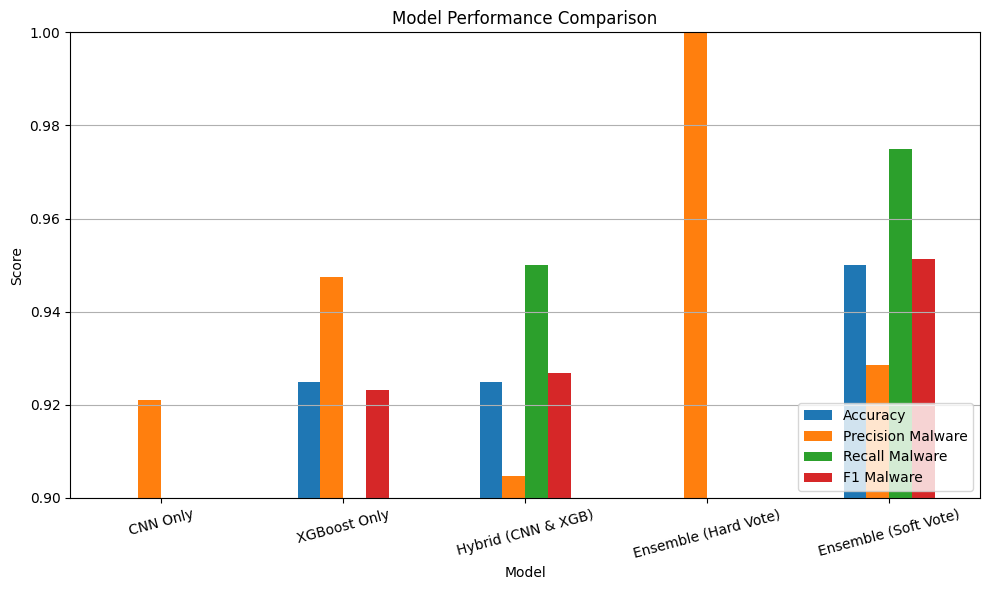

In [21]:
results.plot(kind='bar', figsize=(10, 6), rot=15)
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.ylim(0.9, 1.0)
plt.grid(axis='y')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()